## Importing Libraries

In [2]:
#Basic Functionalities:
import os
import pandas as pd
import numpy as np

#PyTorch
import torchvision
import torch
import timm
from torch import optim
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset
from torch import nn
from torchinfo import summary

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt

# Misc.
import PIL
import cv2
import time
import warnings
from skimage.color import rgb2lab, lab2rgb
from tqdm.notebook import tqdm_notebook

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


### Constants

In [3]:
BATCH_SIZE=8
SEQ_LEN=5

### Dataset Creation

In [4]:
class dataset(Dataset):
    
    def __init__(self, color_dir: str, sequence_len: int = 13):
        self.color_images = sorted([os.path.join(color_dir, i) for i in (os.listdir(color_dir))], key=lambda x: int(x.split("/")[-1].split(".")[0]))
        self.sequence = self.sequencify(self.color_images, sequence_len)

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((256, 256), PIL.Image.BICUBIC),
            torchvision.transforms.RandomHorizontalFlip(),
        ])
        
    def __len__(self):
        return len(self.sequence)

    def sequencify(self, color_images: list, sequence_len: int):
        sequence = [color_images[i:i + sequence_len] for i in range(0, len(color_images), sequence_len)]
        return sequence
                
    def __getitem__(self, index):
        sequence_paths = self.sequence[index]
        to_return = torch.empty((len(sequence_paths), 3, 256, 256))

        for i, path in enumerate(sequence_paths):
            img = PIL.Image.open(path).convert("RGB")
            img = self.transforms(img)
            img_lab = rgb2lab(np.array(img)).astype("float32")
            img_lab = torchvision.transforms.ToTensor()(img_lab)
            to_return[i] = img_lab
            
        return to_return


In [5]:
train_ds=dataset("../Dataset/train_bc/",SEQ_LEN)
test_ds=dataset("../Dataset/test_op/",SEQ_LEN)

#### Checking dataset class

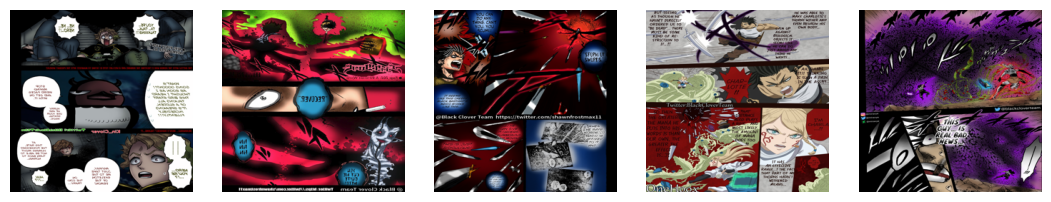

In [6]:
rand = torch.randint(50, (1,))
rand=0
plt.figure(figsize=(15, 12))  

for i in range(1, len(test_ds[rand]) + 1):
    plt.subplot(6, 7, i)
    plt.axis(False)
    plt.imshow(lab2rgb(train_ds[rand][i - 1].permute((1, 2, 0))))

plt.tight_layout()  
plt.show()

#### Data Loaders

In [7]:
train_loader=torch.utils.data.DataLoader(train_ds,BATCH_SIZE)
test_loader=torch.utils.data.DataLoader(test_ds,BATCH_SIZE)

print(f"Train Loader Batch Shape: {next(iter(train_loader)).shape}")
print(f"Test Loader Batch Shape: {next(iter(test_loader)).shape}")

Train Loader Batch Shape: torch.Size([8, 5, 3, 256, 256])
Test Loader Batch Shape: torch.Size([8, 5, 3, 256, 256])


### Model Definition

#### U-Net/GAN

In [8]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss


def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [48]:
class GANModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.data=data
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self, data=None):
        if(data is not None):
            #self.L = data['L'].to(self.device)
            #self.ab = data['ab'].to(self.device)
            self.fake_color = self.net_G(data)
            return self.fake_color
        else:
            self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()


def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(), n_in=n_input, pretrained=True, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G


def finetune_model(model, train_dl, epochs, display_every=200):
    data = next(iter(test_loader)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm_notebook(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

In [10]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = torch.optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        

In [49]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
#net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = GANModel(net_G=net_G)
model.load_state_dict(torch.load("../GDRIVE_FineTuning/fine_tuned_weights(full_model).pt", map_location=device))

model initialized with norm initialization


<All keys matched successfully>

In [11]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)

In [12]:
net_G.load_state_dict(torch.load("../GDRIVE_FineTuning/fine_tuned_generator_weights.pt"))

<All keys matched successfully>

In [13]:
files=next(iter(train_loader))[0]

In [30]:
image=files[0][0].unsqueeze(dim=0)/ 50. - 1. 
image=image.unsqueeze(dim=0)

In [28]:
net_G=net_G.to("cpu")

In [38]:

with torch.inference_mode():
    output1=net_G(image)

In [39]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    

In [40]:
output1.shape

torch.Size([1, 2, 256, 256])

In [59]:
model=model.to("cpu")

In [60]:
with torch.inference_mode():
    output2=model(image)

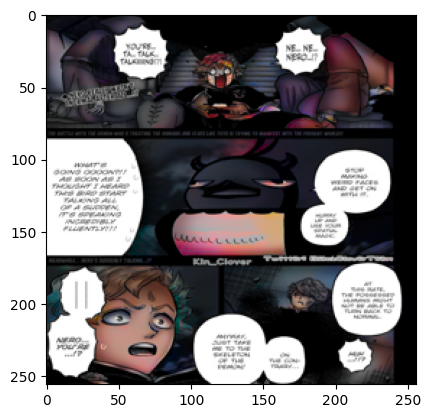

In [62]:
plt.imshow(lab_to_rgb(image,output2)[0])

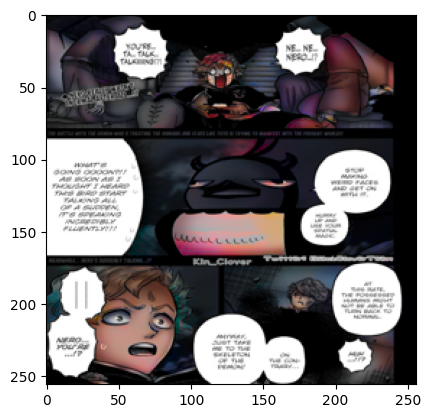

In [44]:
plt.imshow(lab_to_rgb(image,output1)[0])

#### N-dim LSTM

In [ ]:
class NDIM_LSTM(nn.Module):
    
    def __init__(self,size):
        super().__init__()

        self.percent_ltr_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.percent_ltr_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b1=nn.Parameter(torch.tensor(0.),requires_grad=False)

        self.percent_potential_ltm_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.percent_potential_ltm_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b2=nn.Parameter(torch.tensor(0.),requires_grad=False)
        
        self.potential_ltm_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.potential_ltm_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b3=nn.Parameter(torch.tensor(0.),requires_grad=False)
        
        self.output_stm_contri_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.output_stm_contri_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b4=nn.Parameter(torch.tensor(0.),requires_grad=False)

    def lstm_unit(self,input_value,long_memory,short_memory):
        
        long_remember_percent=torch.sigmoid((input_value*self.percent_ltr_input)+
                                            (self.percent_ltr_stm_wt*short_memory)+
                                            self.b1)
        
        potential_remember_percent=torch.sigmoid((input_value*self.percent_potential_ltm_input)+
                                                 (short_memory*self.percent_potential_ltm_stm_wt)+
                                                  self.b2)

        potential_memory = torch.tanh((short_memory * self.potential_ltm_stm_wt) + 
                                  (input_value * self.potential_ltm_input) + 
                                  self.b3)
        
        updated_long_memory = ((long_memory * long_remember_percent) + 
               (potential_remember_percent * potential_memory))

        output_percent = torch.sigmoid((short_memory * self.output_stm_contri_stm_wt) + 
                                       (input_value * self.output_stm_contri_input) + 
                                       self.b4)         
        
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent

        return([updated_long_memory, updated_short_memory])

    def forward(self, input, long_memory=0, short_memory=0): 
        
        return self.lstm_unit(input,long_memory,short_memory)